In [1]:
# import
import os, sys
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.spatial import distance
from sklearn.cluster import KMeans
from tqdm import tqdm

# import plotting libraries
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 10})
plt.rcParams["svg.fonttype"] = "none"
import seaborn as sns
from nilearn import datasets
from nilearn import plotting

sys.path.extend([r'/home/lindenmp/research_projects/snaplab_tools'])
sys.path.extend([r'/home/lindenmp/research_projects/nctpy/src'])

# import nctpy functions
from nctpy.energies import integrate_u, get_control_inputs
from nctpy.pipelines import ComputeControlEnergy, ComputeOptimizedControlEnergy
from nctpy.metrics import ave_control
from nctpy.utils import (
    matrix_normalization,
    convert_states_str2int,
    normalize_state,
    normalize_weights,
    get_null_p,
    get_fdr_p,
)
from nctpy.plotting import roi_to_vtx, null_plot, surface_plot, add_module_lines
from null_models.geomsurr import geomsurr

### Load energy

In [2]:
# directory where data is stored
indir = '/media/lindenmp/storage_ssd/research_projects/nct_xr/data'
outdir = '/home/lindenmp/research_projects/nct_xr/results'
# control_energy_file = 'hcp_control_energy_k-10_T-1_c-1_rho-1.npy'
# control_energy_file = 'hcp_control_energy_k-10_T-1_c-1_rho-0.1.npy'
control_energy_file = 'hcp_optimized_control_energy_k-10_T-1_c-1_rho-1.npy'

In [3]:
control_energy = np.load(os.path.join(outdir, control_energy_file), allow_pickle=True).item()
control_energy.keys()

dict_keys(['control_energy_xf', 'optimized_weights_xf', 'control_energy_midpoint', 'optimized_weights_midpoint', 'control_energy_zero', 'optimized_weights_zero'])

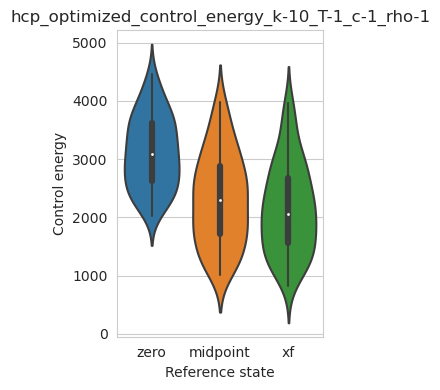

In [4]:
n_states = control_energy['control_energy_zero'].shape[0]
f, ax = plt.subplots(1, 1, figsize=(3, 4))
mask = np.zeros((n_states, n_states)).astype(bool)
mask[np.eye(n_states) == 1] = True
mask = ~mask

# df = pd.DataFrame(index=np.arange((n_states * n_states) - n_states), columns=['zero', 'xf', 'xfx0'])
df = pd.DataFrame(index=np.arange((n_states * n_states) - n_states))
df['zero'] = control_energy['control_energy_zero'][mask]
df['midpoint'] = control_energy['control_energy_midpoint'][mask]
df['xf'] = control_energy['control_energy_xf'][mask]
# for i in np.arange(n_states):
#     x = control_energy['control_energy_ref'][:, :, i].copy()
#     x[i, :] = np.nan
#     x[:, i] = np.nan
#     df['fmri-{0}'.format(i)] = x[mask]

# sns.boxplot(data=df, ax=ax)
sns.violinplot(data=df, ax=ax, scale='width')
ax.set_xlabel('Reference state')
ax.set_ylabel('Control energy')
# sns.kdeplot(data=df, ax=ax)
# ax.set_xlabel('Control energy')
ax.set_title(control_energy_file.split('.')[0])

f.tight_layout()
f.savefig(
    os.path.join(outdir, "{0}.png".format(control_energy_file.split('.')[0])),
    dpi=600,
    bbox_inches="tight",
    pad_inches=0.01,
)
plt.show()

In [5]:
myelin_map = np.load(os.path.join(indir, 'hcp_schaefer400-7_myelin.npy'))
myelin_map = np.mean(myelin_map, axis=1)
myelin_map.shape

(400,)

In [6]:
control_energy['optimized_weights_xf'].shape

(10, 10, 5, 400)

In [7]:
x = -1 -control_energy['optimized_weights_xf']
np.any(x > 0)

False

/home/lindenmp/miniconda3/envs/nct_xr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/lindenmp/miniconda3/envs/nct_xr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/lindenmp/miniconda3/envs/nct_xr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


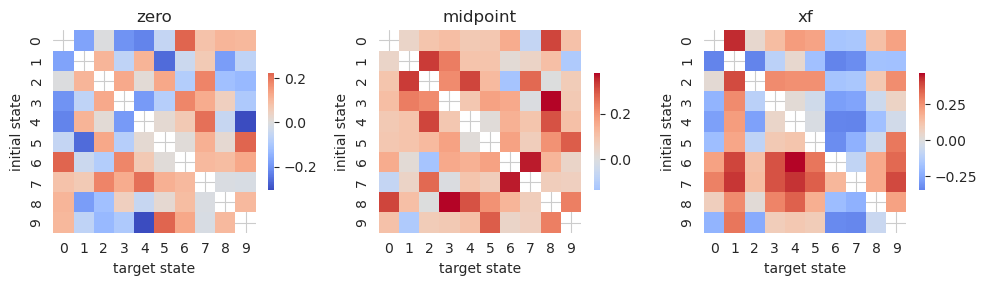

In [8]:
f, ax = plt.subplots(1, 3, figsize=(10, 5))

corr_matrix = np.zeros((n_states, n_states))
for i in np.arange(n_states):
    for j in np.arange(n_states):
        corr_matrix[i, j] = sp.stats.spearmanr(control_energy['optimized_weights_zero'][i, j, -1], myelin_map)[0]
sns.heatmap(corr_matrix, ax=ax[0], square=True, cmap='coolwarm', center=0, cbar_kws={'shrink': 0.25})
ax[0].set_title('zero')

corr_matrix = np.zeros((n_states, n_states))
for i in np.arange(n_states):
    for j in np.arange(n_states):
        corr_matrix[i, j] = sp.stats.spearmanr(control_energy['optimized_weights_midpoint'][i, j, -1], myelin_map)[0]
sns.heatmap(corr_matrix, ax=ax[1], square=True, cmap='coolwarm', center=0, cbar_kws={'shrink': 0.25})
ax[1].set_title('midpoint')

corr_matrix = np.zeros((n_states, n_states))
for i in np.arange(n_states):
    for j in np.arange(n_states):
        corr_matrix[i, j] = sp.stats.spearmanr(control_energy['optimized_weights_xf'][i, j, -1], myelin_map)[0]
sns.heatmap(corr_matrix, ax=ax[2], square=True, cmap='coolwarm', center=0, cbar_kws={'shrink': 0.25})
ax[2].set_title('xf')

for this_ax in ax:
    this_ax.set_ylabel('initial state')
    this_ax.set_xlabel('target state')

f.tight_layout()
plt.show()

In [9]:
corr_matrix = np.zeros((n_states, n_states))
for i in np.arange(n_states):
    for j in np.arange(n_states):
        corr_matrix[i, j] = sp.stats.spearmanr(control_energy['optimized_weights_midpoint'][i, j, -1], myelin_map)[0]

/home/lindenmp/miniconda3/envs/nct_xr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


/tmp/ipykernel_574187/3886066805.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(corr_matrix.flatten())
/home/lindenmp/miniconda3/envs/nct_xr/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

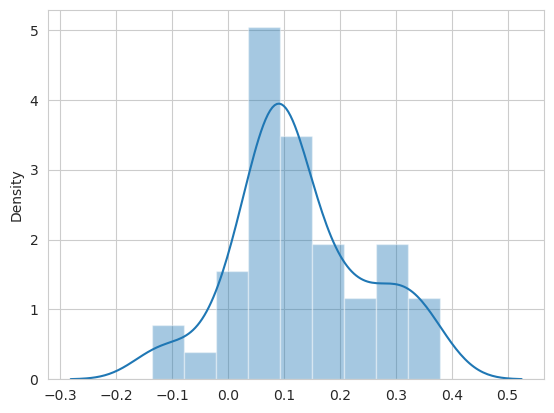

In [11]:
sns.distplot(corr_matrix.flatten())

In [13]:
x = corr_matrix.flatten()
nan_mask = np.isnan(x)

In [19]:
sp.stats.ttest_1samp(x[~nan_mask], popmean=0)

TtestResult(statistic=10.234851469810298, pvalue=1.049498296978831e-16, df=89)

In [ ]:
sp.stats.ttest_rel